#### Import Libraries and define necessary functions

Data Source: [here](https://www.kaggle.com/datasets/yogesh94/m4-forecasting-competition-dataset)

In [3]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from copy import copy
from sklearn.neural_network import MLPRegressor
from sktime.performance_metrics.forecasting import MeanAbsoluteScaledError
from sktime.performance_metrics.forecasting import MeanAbsolutePercentageError
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN
from keras.optimizers import RMSprop
from statsmodels.tsa.api import Holt, SimpleExpSmoothing
from statsmodels.tsa.forecasting.theta import ThetaModel
from scipy.stats import kstest
from tqdm.auto import tqdm
from statsmodels.tsa.stattools import adfuller
from keras.constraints import max_norm
from keras.callbacks import EarlyStopping
from keras.layers import LSTM, Bidirectional,Lambda
from keras import losses
from darts.utils.statistics import check_seasonality
from darts.timeseries import TimeSeries
from tensorflow import expand_dims
from keras.callbacks import Callback
os.chdir(r'C:\archive')

In [4]:
def detrend_deseasonalize(ts, f:str):
    #Make ts stationary
    for i in range(1,10):
        temp=np.diff(ts,i)
        if adfuller(temp)[1]<=0.05:
            break

    dti = pd.date_range("2015-01-01", periods=len(ts), freq=f)
    temp2 = pd.DataFrame(ts,index=dti)

    #Deseasonalize if needed
    temp3=TimeSeries.from_dataframe(temp2)
    status,p=check_seasonality(temp3, alpha=0.05)
    
    if status :
        rolling_mean = temp2.rolling(window = p).mean()
        new_ts = rolling_mean - rolling_mean.shift()
        new_ts.dropna(inplace=True)
        new_ts = new_ts.values.ravel()
        return new_ts
    return temp

In [5]:
def split_into_train_test(data, in_num, fh):
    train, test = data[:-fh], data[-(fh + in_num):]
    x_train, y_train = train[:-1], np.roll(train, -in_num)[:-in_num]
    x_test, y_test = train[-in_num:], np.roll(test, -in_num)[:-in_num]

    # reshape input to be [samples, time steps, features] (N-NF samples, 1 time step, 1 feature)
    x_train = np.reshape(x_train, (-1, 1))
    x_test = np.reshape(x_test, (-1, 1))
    temp_test = np.roll(x_test, -1)
    temp_train = np.roll(x_train, -1)
    for x in range(1, in_num):
        x_train = np.concatenate((x_train[:-1], temp_train[:-1]), 1)
        x_test = np.concatenate((x_test[:-1], temp_test[:-1]), 1)
        temp_test = np.roll(temp_test, -1)[:-1]
        temp_train = np.roll(temp_train, -1)[:-1]

    return x_train, y_train, x_test, y_test

In [6]:
def save_results(y_test,y_pred, method):
    global results, name, y_train
    
    temp = MeanAbsoluteScaledError()
    mase = temp(y_test,y_pred,y_train=y_train)
    temp = MeanAbsolutePercentageError(symmetric=True)
    smape = temp(y_test,y_pred)
    avg = (mase+smape)/2

    results['TimeSeries'].append(name)
    results['MASE'].append(round(mase,2))
    results['sMAPE'].append(round(smape,2))
    results['Average'].append(round(avg,2))
    results['Method'].append(method)

In [7]:
def mlp(x_train, y_train, x_test, layers:tuple, predictions:int):
    x_test1=copy(x_test)
    
    mlp=MLPRegressor(hidden_layer_sizes=layers, activation='relu',
                solver='adam', learning_rate='adaptive',learning_rate_init=0.001, 
                max_iter=2000, random_state=5, tol=0.001, early_stopping=True, verbose=False,
                validation_fraction=0.3).fit(x_train, y_train)

    y_hat_test = []
    for i in range(0, predictions):
        last_prediction = mlp.predict(x_test1)[0]
        y_hat_test.append(last_prediction)

        x_test1[0] = np.roll(x_test1[0], -1)
        x_test1[0, (len(x_test1[0]) - 1)] = last_prediction

    mlp_results=np.asarray(y_hat_test)

    return mlp_results

In [8]:
def rnn(x_train, y_train, x_test, layers:tuple, predictions:int):
    x_test1=copy(x_test)
    
    model = Sequential([
        Lambda(lambda x: expand_dims(x, axis=-1), input_shape=[None]),
        Bidirectional(LSTM(layers[0], dropout=0.6,activation='tanh', return_sequences=True)),
        Bidirectional(LSTM(layers[1], return_sequences=False, activation='relu',use_bias=False, dropout=0.6)),
        Dense(1,activation='linear')
    ])
    opt = RMSprop(learning_rate=0.05)
    model.compile(loss=losses.Huber(), optimizer=opt)

    early_stopping = EarlyStopping(monitor='loss', patience=5, min_delta=0.0001, mode='max')

    early_stopping=EarlyStopping()
    model.fit(x_train, y_train, epochs=2000,validation_split=0.3, verbose=0,callbacks=[early_stopping])

    # make predictions
    y_hat_test = []
    for i in range(0, predictions):
        last_prediction = model.predict(x_test1,verbose=0)[0]
        y_hat_test.append(last_prediction[0])
        x_test1[0] = np.roll(x_test1[0], -1)
        x_test1[0, (len(x_test1[0]) - 1)] = last_prediction

    rnnResults=np.asarray(y_hat_test)
    return rnnResults

In [9]:
def theta(ts, predictions:int):
    thetas = np.linspace(1, 20, 50).round(1)

    best_mape = float('inf')
    best_theta = 0

    for i in thetas:
        model = ThetaModel(ts[:-predictions], deseasonalize=False).fit()
        thetaResults=model.forecast(predictions,theta=i).values
        smape = MeanAbsolutePercentageError(symmetric=True)
        smape=smape(ts[-predictions:], thetaResults)

        if smape < best_mape:
            best_mape = smape
            best_theta = i

    thetaResults=model.forecast(predictions,theta=2).values
    return thetaResults

In [10]:
def holt(ts, predictions:int):
    holt = Holt(ts[:-predictions]).fit(smoothing_level = 0.3,smoothing_trend = 0.1)
    holtResults=holt.forecast(predictions)
    return holtResults

In [11]:
def naive(ts,predictions:int):
    train=ts[:-predictions]
    naiveResult=[train[-1] for i in range(predictions)]
    return np.asarray(naiveResult)

In [12]:
def ses(ts,predictions):
    ses = SimpleExpSmoothing(ts[:-predictions]).fit()
    sesResults = ses.forecast(predictions)
    return sesResults

In [13]:
def bootstrap_residuals(residuals): 
    bs_stds=[]
    last_std = None

    for i in range(10000):
        samples = [residuals[np.random.randint(len(residuals))] for x in range(len(residuals))]
        bs_stds.append(np.std(samples))
        if i%500 == 0 and i!=0:
            if i == 500:
                last_std = np.median(bs_stds)
            else:
                current_std = np.median(bs_stds)
                if abs(current_std - last_std) < last_std*0.00001:
                    break
                else:
                    last_std = np.median(bs_stds)        
        
    bs_std = np.median(bs_stds)
    return bs_std

---
#### Visualizing the predictions of one Time Series

In [228]:
df=pd.read_csv('Hourly-train.csv', nrows=2)
ts_=df.loc[1].dropna().values[1:] #original
name=df.loc[1].dropna().values[0]

ad=adfuller(ts_)[1]
if ad>0.05:
    ts=detrend_deseasonalize(ts_,name[0])
    print("Ts was not stationary !")
    print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
else:
    ts=copy(ts_)
    print("Ts was stationary !")
    print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")

x_train, y_train, x_test, y_test=split_into_train_test(list(ts),24,48)

mlpResults=mlp(x_train, y_train, x_test,(48,24), 48)
rnnResults=rnn(x_train, y_train, x_test,(48,24), 48)
thetaResults=theta(ts, 48)
holtResults=holt(ts, 48)
naiveResults=naive(ts, 48)
sesResults=ses(ts, 48)

forecasts=[mlpResults,rnnResults,thetaResults,holtResults,naiveResults,sesResults]
methods=["MLP","RNN","Theta","Holt","Naive","SES"]
for i,method in enumerate(methods):
    residuals = sorted([x - y for x, y in zip(forecasts[i], ts)])
    print(f"Residuals Ktest pvalue - {method}: {round(kstest(residuals,'norm').pvalue,2)}")

Ts was not stationary !
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Residuals Ktest pvalue - MLP: 0.0
Residuals Ktest pvalue - RNN: 0.0
Residuals Ktest pvalue - Theta: 0.0
Residuals Ktest pvalue - Holt: 0.0
Residuals Ktest pvalue - Naive: 0.0
Residuals Ktest pvalue - SES: 0.0


In [229]:
bs_stds={name: (bootstrap_residuals(forecasts[i])) for i,name in enumerate(methods)}
sizes={i: (1.96*bs_stds[i]) for i in bs_stds.keys()}
sizes

{'MLP': 358.81097034572275,
 'RNN': 6.509181690216065,
 'Theta': 0.25013736625045296,
 'Holt': 449.22400539607935,
 'Naive': 0.0,
 'SES': 0.0}

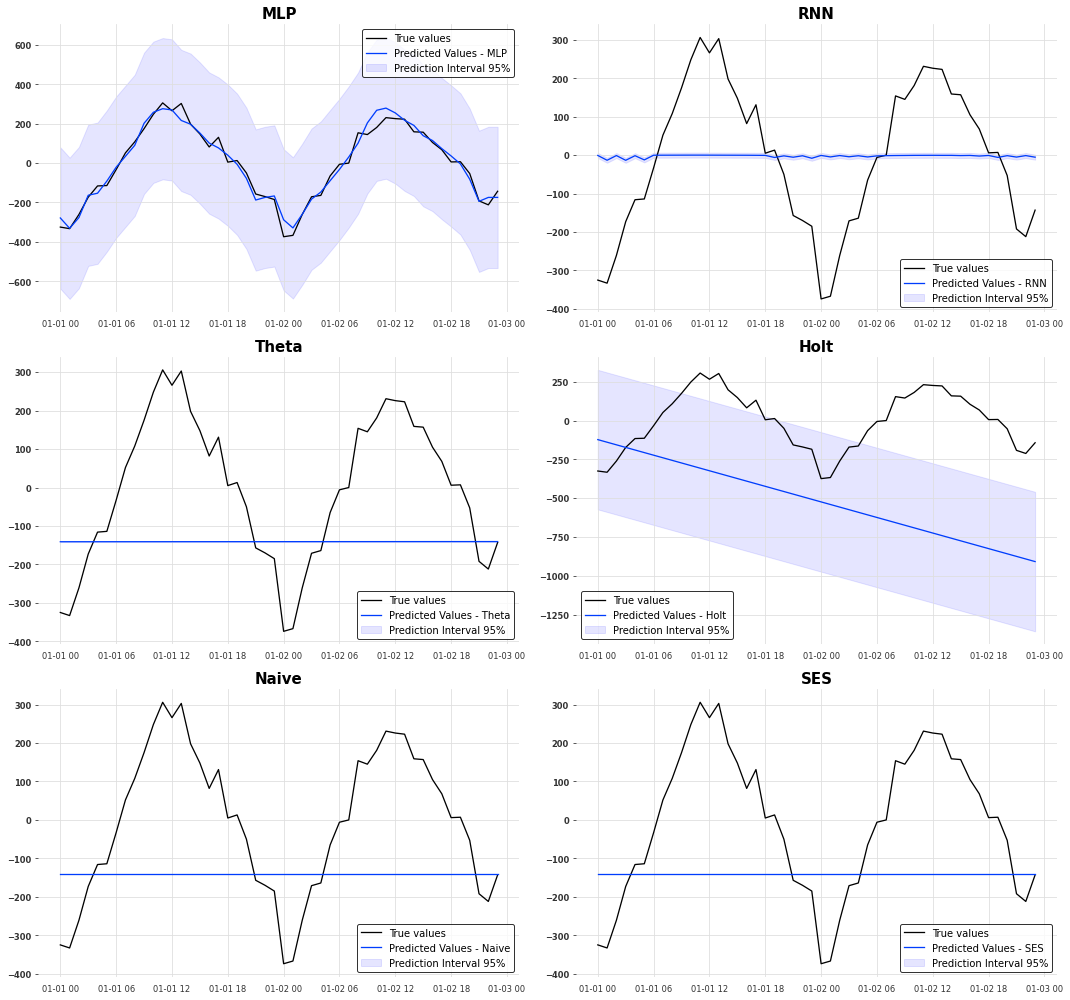

In [230]:
dti = pd.date_range("2015-01-01", periods=48, freq='H')
temp0=pd.DataFrame(y_test,index=dti)
temp1=pd.DataFrame(mlpResults,index=dti)
temp2=pd.DataFrame(rnnResults,index=dti)
temp3=pd.DataFrame(thetaResults,index=dti)
temp4=pd.DataFrame(holtResults,index=dti)
temp5=pd.DataFrame(naiveResults,index=dti)
temp6=pd.DataFrame(sesResults,index=dti)

dfs=[temp1,temp2,temp3,temp4,temp5,temp6]
plt.figure(figsize=(15, 14))
for i,method in enumerate(methods):
    ax = plt.subplot(3, 2, i+1)
    plt.yticks(fontweight="bold")
    ax.set_title(method,fontsize=15, fontweight="bold")
    ax.plot(temp0, label='True values')
    ax.plot(dfs[i], label=f"Predicted Values - {method}")
    ax.fill_between(dfs[i].index, (forecasts[i]-sizes[method]), (forecasts[i]+sizes[method]), color='b', alpha=.1, label='Prediction Interval 95%')
    ax.legend(frameon=True).get_frame().set_edgecolor('k')
 
plt.tight_layout()
plt.show()

In [231]:
#Use cusum to project predictions to the stage before the differencing
dti = pd.date_range("2015-01-01", periods=len(ts_), freq='H')
temp0=pd.DataFrame(ts_,index=dti)

#Projected values need vertical shift. Finding the constant
all2=[mlpResults,rnnResults]
var_names=["MLP","RNN"]
values={var_names[index]: (temp0[:-48].values[-1][0]-x.cumsum()[0]) for index,x in enumerate(all2)}
values

{'MLP': 3611.690187291032, 'RNN': 3333.84553194046}

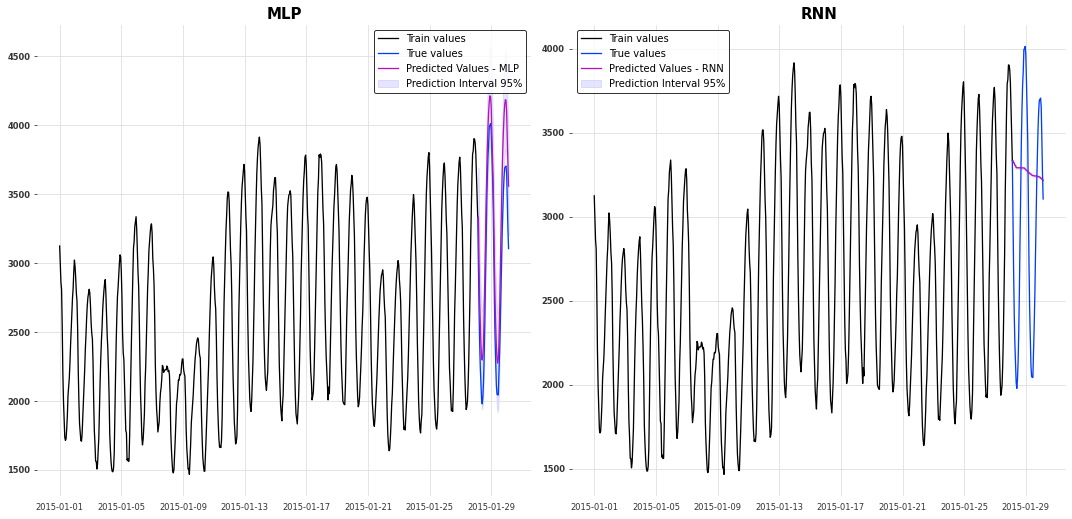

In [233]:
#Add vertical shift
temp1=pd.DataFrame(mlpResults.cumsum()+values['MLP'],index=dti[-48:])
temp2=pd.DataFrame(rnnResults.cumsum()+values['RNN'],index=dti[-48:])

dfs=[temp1,temp2]
plt.figure(figsize=(15, 14))
for i,method in enumerate(var_names):
    ax = plt.subplot(2, 2, i+1)
    plt.yticks(fontweight="bold")
    ax.plot(temp0[:-48],label='Train values')
    ax.set_title(method,fontsize=15, fontweight="bold")
    ax.plot(temp0[-49:], label='True values')
    ax.plot(dfs[i], label=f"Predicted Values - {method}")
    ax.fill_between(dfs[i].index, (forecasts[i].cumsum()+values[method]-sizes[method]), (forecasts[i].cumsum()+values[method]+sizes[method]), color='b', alpha=.1, label='Prediction Interval 95%')
    ax.legend(frameon=True).get_frame().set_edgecolor('k')
 
plt.tight_layout()
plt.show()

---
#### Prediction for multiple Time Series

In [36]:
params=[{'file':'Hourly-train.csv', 'predictions':48, 'backsteps':24, 'layers':(48,24)},
{'file':'Daily-train.csv', 'predictions':14, 'backsteps':7, 'layers':(14,7)},
{'file':'Weekly-train.csv', 'predictions':13, 'backsteps':7, 'layers':(13,7)},
{'file':'Monthly-train.csv', 'predictions':18, 'backsteps':12, 'layers':(18,12)},
{'file':'Quarterly-train.csv', 'predictions':8, 'backsteps':4, 'layers':(8,4)},
{'file':'Yearly-train.csv', 'predictions':6, 'backsteps':3, 'layers':(6,3)}]

In [ ]:
results={}
results['TimeSeries']=[]
results['MASE']=[]
results['sMAPE']=[]
results['Average']=[]
results['Method']=[]

for param in tqdm(params):
    df=pd.read_csv(param['file'], nrows=5)
    for i in range(0,5):

        ts = df.loc[i].dropna().values[1:]
        name = df.loc[i].dropna().values[0]
        ts = np.asarray(ts).astype('float32')

        ad=adfuller(ts)[1]
        if ad>0.05:
            ts=detrend_deseasonalize(ts,name[0])

        x_train, y_train, x_test, y_test = split_into_train_test(ts, param['backsteps'], param['predictions'])

        mlpResults=mlp(x_train, y_train, x_test, param['layers'], param['predictions'])
        save_results(y_test, mlpResults, method ='MLP')

        rnnResults=rnn(x_train, y_train, x_test, param['layers'], param['predictions'])
        save_results(y_test, rnnResults, method ='RNN')

        holtResults=holt(ts, param['predictions'])
        save_results(y_test, holtResults, method ='Holt')

        thetaResults=theta(ts, param['predictions'])
        save_results(y_test, thetaResults, method ='Theta')

        naiveResults=naive(ts, param['predictions'])
        save_results(y_test, naiveResults, method ='Naive')

        sesResults=ses(ts, param['predictions'])
        save_results(y_test, sesResults, method ='SES')


results=pd.DataFrame.from_dict(results)
pd.set_option('display.float_format',  '{:,}'.format)
pd.set_option('display.float_format',  '{:,.2f}'.format)

In [42]:
results.head(10)
# results.to_excel('results.xlsx')

,TimeSeries,MASE,sMAPE,Average,Method
0,H1,0.67,0.48,0.58,MLP
1,H1,2.39,1.65,2.02,RNN
2,H1,9.58,1.61,5.60,Holt
3,H1,4.35,1.36,2.86,Theta
4,H1,4.35,1.36,2.86,Naive
5,H1,4.34,1.36,2.85,SES
6,H2,0.47,0.38,0.42,MLP
7,H2,2.81,1.82,2.32,RNN
8,H2,9.25,1.55,5.40,Holt
9,H2,3.36,1.34,2.35,Theta


In [43]:
results.sort_values('Average').head(10).reset_index(drop=True)

,TimeSeries,MASE,sMAPE,Average,Method
0,D3,0.00,0.01,0.00,Naive
1,W5,0.17,0.08,0.13,RNN
2,W5,0.17,0.08,0.13,Naive
3,Q2,0.30,0.01,0.15,SES
4,Q4,0.48,0.01,0.25,SES
5,W5,0.37,0.17,0.27,Theta
6,Q2,0.52,0.01,0.27,Theta
7,W5,0.37,0.17,0.27,SES
8,Q4,0.61,0.01,0.31,Naive
9,D5,0.12,0.71,0.41,Holt


In [41]:
temp = copy(results)
temp['Frequency'] = temp.TimeSeries.apply(lambda x: x[0])
freq = temp.Frequency.unique().tolist()
temp = temp.set_index(['Frequency','Method'])

temp2 = [temp.query(f'Frequency=="{f}"').nsmallest(1,columns='Average',keep='all') for f in freq]
temp2=pd.concat(temp2, axis=0)
temp2.index.names = ['Frequency','Best Method']
temp2

TimeSeries  MASE  sMAPE  Average
Frequency Best Method                                 
H         MLP                 H2  0.47   0.38     0.42
D         Naive               D3  0.00   0.01     0.00
W         RNN                 W5  0.17   0.08     0.13
          Naive               W5  0.17   0.08     0.13
M         SES                 M5  0.90   0.01     0.45
Q         SES                 Q2  0.30   0.01     0.15
Y         Naive               Y2  0.40   0.41     0.41
          SES                 Y2  0.40   0.41     0.41